In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import pylab as plt
import xarray as xr
import seaborn as sns
import nc_time_axis
from joblib import Parallel, delayed
from tqdm import tqdm
import joblib
import contextlib
from scipy.signal import savgol_filter

In [2]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        """TQDM Callback"""

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()


In [3]:
df = pd.read_csv("kennicott-profile.csv")

In [4]:
x = df["x"].values
surface = df["elevation"].values
x = np.hstack([x, 60e3])
surface = np.hstack([surface, 200])

In [5]:
dx = 100
Lx = 60e3
nx = int(Lx / dx)
x_new = np.linspace(dx, Lx, nx)
f = interp1d(x, surface, kind="quadratic")
surface_new = f(x_new)

In [6]:
surface_filtered = savgol_filter(surface_new, window_length=6, polyorder=5, mode="interp")

(0.0, 10000.0)

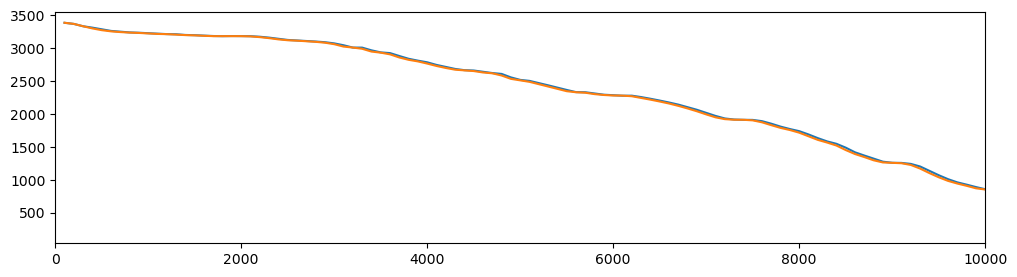

In [7]:
fig = plt.figure(figsize=[12, 3])
ax = fig.add_subplot(111)
ax.plot(x_new, surface_new)
ax.plot(x_new, surface_filtered)
ax.set_xlim(0, 10e3)

In [8]:
df_new = pd.DataFrame(data=np.vstack([x_new, surface_new, surface_new]).T, columns=["x", "bed", "surface"])

In [9]:
df_new.to_csv("kennicott-profile-100m.csv")

In [10]:
from glob import glob

In [11]:
uq_df = pd.read_csv("ensemble_kennicott_climate_lhs_500.csv")

In [12]:
savgol_filter?

In [13]:
def process_ensemble(m_file, params_df):
    with xr.open_dataset(m_file) as ds:
        m_id = int(m_file.split(".")[0].split("_")[-3])
        x = ds["x"]
        bed = ds["topg"][-1,-1,:]
        thickness = ds["thk"][-1,-1,:]
        surface = ds["usurf"][-1,-1,:]
        speed = ds["velsurf_mag"][-1,-1,:]
        speed = speed.where(thickness>10)
        temp_pa = ds["temp_pa"][-1,-1,:, 0]
        temp_pa = temp_pa.where(thickness>10)
        params = params_df[params_df["id"] == m_id]
        ela =  params["ela"].values[0]
        try:
            f = interp1d(surface, x)
            x_ela = f(ela)
        except:
            pass
        try:
            f = interp1d(x, thickness)
            thickness_ela = f(x_ela)
        except:
            pass
        try:
            f = interp1d(x, temp_pa)
            temp_pa_ela = f(x_ela)
        except:
            pass
        log_like = 0.0
        try:
            idx = np.where(thickness.where(surface<3000)[:].values == 0)[0]
            if len(idx) != 0:
                exp = x.to_numpy()[idx[0]]
                log_like -= 0.5 * (
                    (exp - observed_mean) / observed_std
                    ) ** 2 + 0.5 * np.log(2 * np.pi * observed_std**2)
        except ValueError:
            pass
    d =  {"id": m_id, 
            "data": {"x": x, 
                     "thickness": thickness.to_numpy(),
                     "bed": bed.to_numpy(),
                     "surface": surface.to_numpy(), 
                     "speed": speed.to_numpy(), 
                     "temp_pa": temp_pa.to_numpy(), 
                     "ela": ela}}
    if log_like != 0:
        d["data"]["log_like"] = log_like
    return d
   

In [14]:
fontsize = 8
lw = 1.0
aspect_ratio = 1
markersize = 1

params = {
    "backend": "ps",
    "axes.linewidth": 0.25,
    "lines.linewidth": lw,
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "xtick.direction": "in",
    "xtick.labelsize": fontsize,
    "xtick.major.size": 2.5,
    "xtick.major.width": 0.25,
    "ytick.direction": "in",
    "ytick.labelsize": fontsize,
    "ytick.major.size": 2.5,
    "ytick.major.width": 0.25,
    "legend.fontsize": fontsize,
    "lines.markersize": markersize,
    "font.size": fontsize,
}

plt.rcParams.update(params)


In [25]:
observed_mean = 22_000
observed_std = 1000

odir = "2023_06_20_uq_climate_phi_30/"

m_files = glob(f"{odir}/state/kennicott_*.nc")
n_files = len(m_files)
n_jobs = 1

In [26]:
        with tqdm_joblib(tqdm(desc="Processing ensemble", total=n_files)) as progress_bar:
            df = Parallel(n_jobs=n_jobs)(
                delayed(process_ensemble)(
                    m_file, uq_df
                )
                for m_file in m_files
            )
            del progress_bar


Processing ensemble: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 19.41it/s]


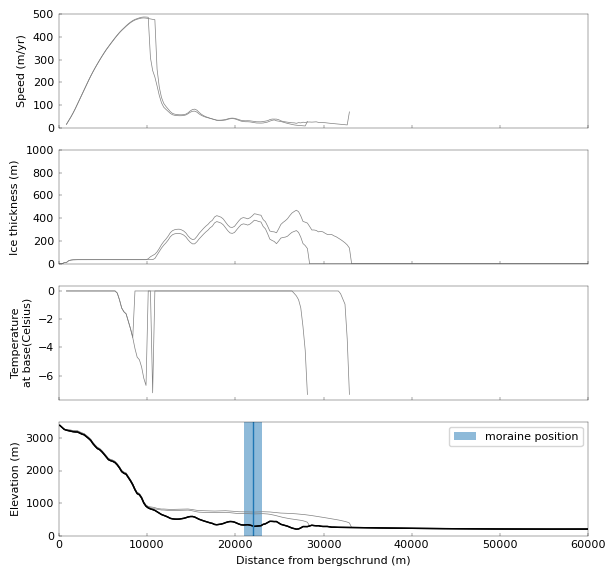

In [27]:
X = np.array([d["data"]["x"] for d in df]).T
Bed = np.array([d["data"]["bed"] for d in df]).T
Surface = np.array([d["data"]["surface"] for d in df]).T
Thickness = np.array([d["data"]["thickness"] for d in df]).T
Speed = np.array([d["data"]["speed"] for d in df]).T
Temp_pa = np.array([d["data"]["temp_pa"] for d in df]).T
log_likes = np.array([d["data"]["log_like"] for d in df if "log_like" in d["data"]]).T
id_log_likes = np.array([d["id"] for d in df if "log_like" in d["data"]]).T

fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=[6.2, 5.8])
fig.subplots_adjust(bottom=0, top=1, left=0, right=1, wspace=0, hspace=0)
axs[0].plot(X, Speed, color="0.5", lw=0.5)
axs[1].plot(X, Thickness, color="0.5", lw=.5)
axs[2].plot(X, Temp_pa, color="0.5", lw=.5)
axs[-1].plot(X, Surface, color="0.5", lw=0.5)
axs[-1].plot(X, Bed[:, 0], color="k")
axs[-1].axvline(observed_mean)
axs[-1].fill_betweenx([0, 3500], observed_mean-observed_std, observed_mean+observed_std, alpha=0.5, label="moraine position")
axs[0].set_ylabel("Speed (m/yr)")
axs[0].set_ylim(0, 500)
axs[1].set_ylim(0, 1000)
axs[-1].set_ylim(0, 3500)
axs[-1].set_xlim(0, 60000)
axs[1].set_ylabel("Ice thickness (m)")
axs[2].set_ylabel("Temperature\nat base(Celsius)")
axs[-1].set_ylabel("Elevation (m)")
axs[-1].set_xlabel("Distance from bergschrund (m)")
axs[-1].legend()
fig.tight_layout()
fig.savefig(f"{odir}/kennicott_profile_plot.pdf")


In [332]:
    experiments = np.array(id_log_likes)
    w = np.array(log_likes)
    w -= w.mean()
    weights = np.exp(w)
    weights /= weights.sum()
    resampled_experiments = np.random.choice(experiments, len(experiments), p=weights)


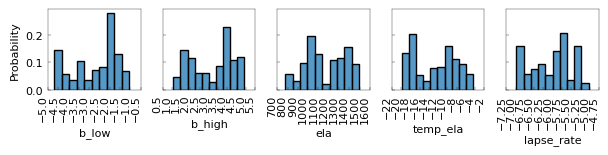

In [333]:
d = []
for e in resampled_experiments:
    d.append(uq_df[uq_df["id"] == int(e)])
df = pd.concat(d).reset_index(drop=True)
fig, axs = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=[6.2, 1.6])
fig.subplots_adjust(bottom=0, top=1, left=0, right=1, wspace=-1, hspace=-1)
for k, v in enumerate(["b_low", "b_high", "ela", "temp_ela", "lapse_rate"]):
    sns.histplot(data=df, x=v, stat="probability", ax=axs.ravel()[k])
    axs.ravel()[k].set_xticks(axs.ravel()[k].get_xticks(), 
                              axs.ravel()[k].get_xticklabels(), 
                              rotation=90, ha='right')

fig.tight_layout()
fig.savefig("2023_06_02_uq_climate/kennicott_hists.pdf")

In [328]:
!open 2023_06_06_uq_climate/kennicott_hists.pdf

In [295]:
print(np.mean(temps_pa_ela))
print(np.std(temps_pa_ela))


-1.0565873489099569
2.947200399613775


(array([  2.,   2.,   5.,   6.,   2.,   6.,   3.,   3.,   1., 210.]),
 array([-14.64304668, -13.17874202, -11.71443735, -10.25013268,
         -8.78582801,  -7.32152334,  -5.85721867,  -4.39291401,
         -2.92860934,  -1.46430467,   0.        ]),
 <BarContainer object of 10 artists>)

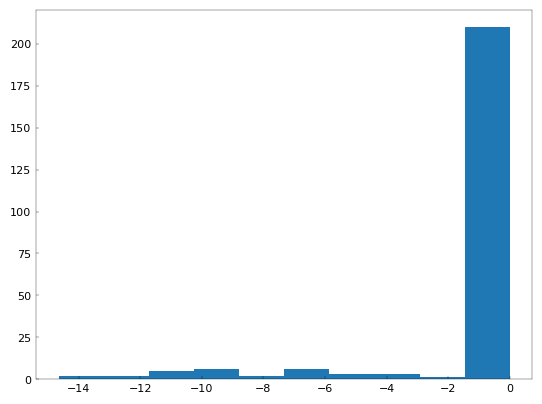

In [296]:
plt.hist(temps_pa_ela)

(array([171.,  15.,  17.,   9.,  12.,  10.,   2.,   1.,   1.,   2.]),
 array([ 22.95732813, 101.33965257, 179.721977  , 258.10430144,
        336.48662588, 414.86895032, 493.25127475, 571.63359919,
        650.01592363, 728.39824807, 806.7805725 ]),
 <BarContainer object of 10 artists>)

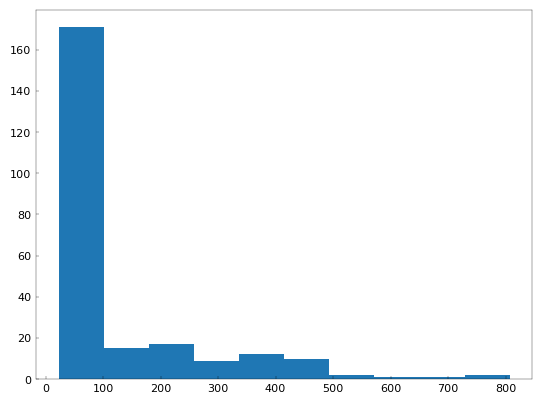

In [297]:
plt.hist(thicknesses_ela)

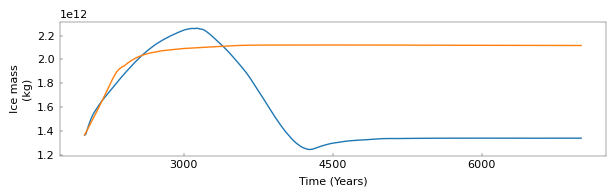

In [19]:

fig = plt.figure(figsize=[6.2, 2])
ax = fig.add_subplot(111)

for m_file in ["2023_06_20_uq_climate_phi_30/scalar/ts_kennicott_id_0_0_5000.nc", 
               "2023_06_20_uq_climate_phi_90/scalar/ts_kennicott_id_0_0_5000.nc"]:
               
    with xr.open_dataset(m_file) as ds:
        m_id = int(m_file.split(".")[0].split("_")[-3])
        time = ds["time"]
        mass = ds["ice_mass"]
        ax.plot(time, mass)

ax.set_xlabel("Time (Years)")
ax.set_ylabel("Ice mass\n(kg)")
fig.tight_layout()
fig.savefig("2023_06_20_uq_climate/kennicott_mass_ts.pdf")

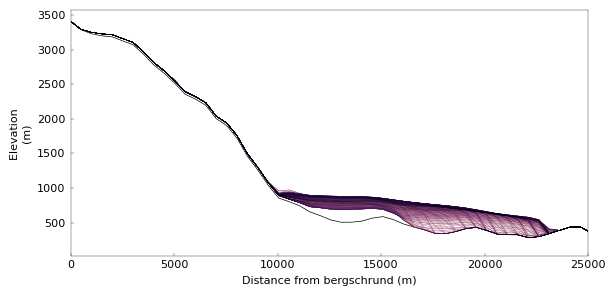

In [299]:
import matplotlib.colors as colors
import matplotlib.cm as cmx


fig = plt.figure(figsize=[6.2, 3])
ax = fig.add_subplot(111)

cmap = plt.get_cmap("magma_r")
cNorm = colors.Normalize(vmin=0, vmax=len(time))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)


for m_file in ["2023_06_02_uq_climate/spatial_kennicott_id_100_0_5000.nc"]:
               
    with xr.open_dataset(m_file) as ds:
        m_id = int(m_file.split(".")[0].split("_")[-3])
        time = ds["time"]
        nt = len(time)
        colorVals = scalarMap.to_rgba(range(0, nt))
        x = ds["x"]
        bed = ds["topg"][0, 0, :]
        surface = ds["usurf"][:, 0, :]
        thickness = ds["thk"][:, 0, :]
        ax.plot(x, bed, lw=0.5, color="k")
        for k in range(0, nt, 25):
            ax.plot(x, surface[k, :], color=colorVals[k], lw=0.2)

ax.set_xlabel("Distance from bergschrund (m)")
ax.set_ylabel("Elevation \n(m)")
ax.set_xlim(0, 25e3)
fig.tight_layout()
fig.savefig("2023_06_02_uq_climate/kennicott_glacier_ts.pdf")

In [300]:
!open 2023_06_02_uq_climate/kennicott_glacier_ts.pdf

In [58]:
bed

<xarray.DataArray 'topg' (time: 5000, y: 3, x: 150)>
[2250000 values with dtype=float32]
Coordinates:
  * time     (time) object 10001-07-02 12:00:00 ... 15000-07-02 12:00:00
  * x        (x) float64 0.0 502.7 1.005e+03 ... 7.389e+04 7.44e+04 7.49e+04
  * y        (y) float64 -100.0 0.0 100.0
Attributes:
    units:          m
    long_name:      bedrock surface elevation
    pism_intent:    model_state
    standard_name:  bedrock_altitude

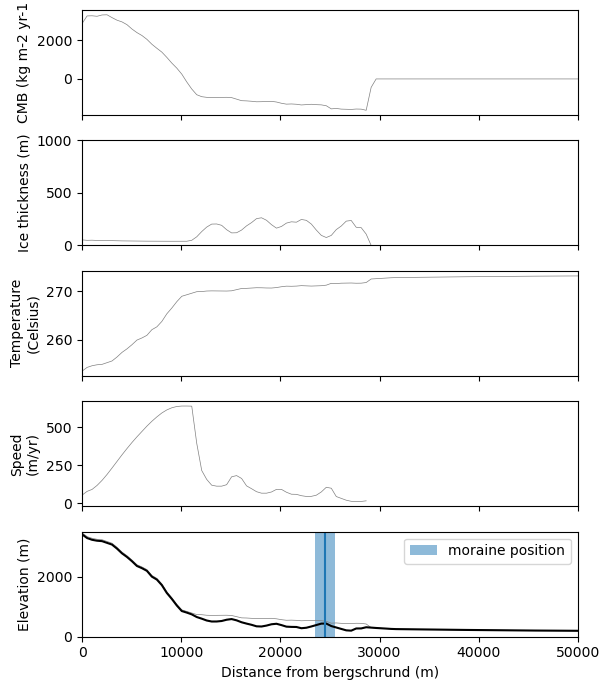

In [118]:

m_file ="ltop_hy.nc"
               
with xr.open_dataset(m_file) as ds:
    X = ds["x"]
    Bed = ds["topg"][0, 0, :]
    Surface = ds["usurf"][0, 0, :]
    Thickness = ds["thk"][0, 0, :]
    Temp = ds["effective_ice_surface_temp"][0, 0, :]
    Cmb = ds["climatic_mass_balance"][0, 0, :]
    Speed = ds["velsurf_mag"][0, 0, :]

fig, axs = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=[6.2, 7])
axs[0].plot(X, Cmb, color="0.5", lw=0.5)
axs[1].plot(X, Thickness, color="0.5", lw=.5)
axs[2].plot(X, Temp, color="0.5", lw=.5)
axs[3].plot(X, Speed, color="0.5", lw=.5)
axs[-1].plot(X, Surface, color="0.5", lw=0.5)
axs[-1].plot(X, Bed, color="k")
axs[-1].axvline(observed_mean)
axs[-1].fill_betweenx([0, 3500], observed_mean-observed_std, observed_mean+observed_std, alpha=0.5, label="moraine position")
axs[0].set_ylabel("CMB (kg m-2 yr-1")
#axs[0].set_ylim(0, 1000)
axs[1].set_ylim(0, 1000)
axs[-1].set_ylim(0, 3500)
axs[-1].set_xlim(0, 50000)
axs[1].set_ylabel("Ice thickness (m)")
axs[2].set_ylabel("Temperature\n(Celsius)")
axs[3].set_ylabel("Speed\n(m/yr)")
axs[-1].set_ylabel("Elevation (m)")
axs[-1].set_xlabel("Distance from bergschrund (m)")
axs[-1].legend()
fig.tight_layout()

fig.savefig("ltop.pdf")

In [93]:
!open ltop.pdf

In [302]:
!open 2023_06_06_uq_climate/kennicott_profile_plot.pdf